<div style="padding:30px; color: white; background-color: #0071CD">
<center>
<img src="img/logoub.jpeg"></img>
<center>
<h1>Algorísmica Avançada</h1>
<h2>Skyscraper Puzzle</h2>
</center>
</div>

In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Problema: Edificis

Volem solucionar el puzzle dels edificis. Donada una graella com la que tenim a continuació (esquerra), volem trobar la solució al puzzle (dreta):

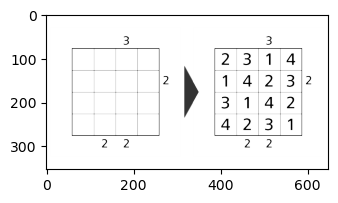

In [2]:
from matplotlib import pyplot as plt
im = plt.imread("img/sky-intro.png")
fig, ax = plt.subplots(figsize=(4, 2))
ax.imshow(im)
plt.show()

Podem pensar que cada una de les caselles és un solar on hi podem posar un edifici de X plantes. En aquest cas un edifici de 1,2,3 o 4 plantes ja que el tauler és de 4x4.<br>
Els números que trobem a fora de la graella ens indiquen quants edificis són visibles des d'aquesta posició. Un edifici d'alçada 4 tapa qualsevol edifici que hi ha al darrere com podeu veure en la imatge següent:

<img src="img/sky-rule-3-1.png" width='20%'></center>

A més, en cada fila i columna de la graella només pot haver-hi un sol edifici de cada alçada, és a dir, no es poden repetir.

<img src="img/skyscrapers.png" width='20%'></center>

        L'objectiu és doncs, donada una graella com la inicial, trobar la configuració d'edificis que satisfà les condicions. Implementeu un algorisme usant backtracking que <b>trobi una solució utilitzant el mínim nombre de crides recursives i minimitzant el temps total d'execució</b>. Per fer-ho haureu de tenir en comptes diferents factors com ara:
-  Quin número començareu provant?
-  Quina casella serà la primera que omplireu?

La funció **format_sky** us ajudarà a visualitzar el tauler del problema.

In [3]:
import numpy as np
from IPython.display import clear_output
import time

def format_sky(board, top, bottom, left, right):
    """
    Funció auxiliar per mostrar la matriu del Problema 1 en forma de graella.
    """
    _str = ""
    
    # Files
    for v in top:
        _str+="   "+str(v)
    _str = "  " + _str + "\n"

    for idx, i in enumerate(board):
        _str+= "   +"+ ("-"*((board.shape[1]*4)-1)) +"+\n"
        _str+= f" {left[idx]} | "
        
        # Columnes
        for j in i:   
            if j!=0:
                _str+= str(j)+" | "
            else:
                 _str+= "  | "
            
        _str+= f"{right[idx]} \n"
    _str+= "   +"+ ("-"*((board.shape[1]*4)-1))+"+\n"
    
    _bot = ""
    for v in bottom:
        _bot+="   "+str(v)
    _str += "  " + _bot
    
    return _str.replace('0',' ')

Veieu un exemple de com utilitzar aquesta funció:


In [4]:
# Amb aquesta funció es mostren totes les caselles del tauler
# Les caselles que contenen un zero es mostren buides

# Creem unes restriccions i un tauler 
top, bottom, left, right = [0,0,0], [3,0,0], [0,0,0], [0,0,1]
grid = np.zeros((len(left), len(top)), dtype='int')

print('Tauler:')
print(format_sky(grid, top, bottom, left, right))

Tauler:
              
   +-----------+
   |   |   |   |   
   +-----------+
   |   |   |   |   
   +-----------+
   |   |   |   | 1 
   +-----------+
     3        


La funció **delayed_print** us permet bloquejar temporalment un 'print' per si voleu veure les accions que fa a cada pas el vostre algorisme.<br>
No heu d'utilitzar-la a l'entrega ja que el programa tardarà molt més del necessari, utilitzeu-la només mentre programeu la solució.

In [5]:
def delayed_print(grid, top, bottom, left, right, sleep_time=0.02):
    """
    Funció auxiliar que bloqueja temporalment la funció 'print' per veure l'evolució de l'algorisme.
    """
    print(format_sky(grid, top, bottom, left, right))
    clear_output(wait=True)
    time.sleep(sleep_time)

In [6]:
top, bottom, left, right = [0,0,0], [3,0,0], [0,0,0], [0,0,1]
grid = np.zeros((len(left), len(top)), dtype='int')

for i in range(0, len(left)):
    for j in range(0, len(top)):
        grid[i][j] = np.random.randint(1,4)
        delayed_print(grid, top, bottom, left, right, sleep_time=0.25)

              
   +-----------+
   | 2 | 3 | 3 |   
   +-----------+
   | 2 | 3 | 1 |   
   +-----------+
   | 1 | 2 | 3 | 1 
   +-----------+
     3        


In [7]:
def count_restrictions(x, y, top, bottom, left, right):
    # Conta les restriccions (numeros fora la matriu) en la posició (x,y)
    count = 0
    if top[y] != 0:
        count += 1
    if bottom[y] != 0:
        count += 1
    if left[x] != 0:
        count += 1
    if right[x] != 0:
        count += 1
    return count

def find_empty_location(grid, top, bottom, left, right):
    empty_locations = []
    
    for i in range(len(grid)):
        for j in range(len(grid)):
            if grid[i][j] == 0:
                num_restricts = count_restrictions(i, j, top, bottom, left, right)
                empty_locations.append(((i, j), num_restricts))
    
    # Ordena la llista pel numero de restriccions, de major a menor
    empty_locations.sort(key=lambda x: x[1], reverse=True)
    
    # Retorna la posició (1er valor de la 1a tupla) que te més restriccions
    return empty_locations[0][0] if empty_locations else None

def vision_of(fila):
    # Conta el nombre de edificis que es veuen en la fila
    count = 1
    maxim = fila[0]
    for i in range(1,len(fila)):
        if maxim < fila[i]:
            count += 1
            maxim = fila[i]
    return count


def satisfies(grid, x, y, num, top, bottom, left, right):
    """
    Donat un tauler, un punt amb coordenades (x,y) i un nombre 'num', comprova si és possible assignar-lo a la posició (x,y) 
    donades les restriccions del problema.
    
    Params
    ------
    :grid: Una matriu de numpy
    :x,y: Un punt de la matriu on volem posar el nombre 'num'
    :num: Un nombre enter
    :top, bottom, left, right: Els nombres de fora del tauler de la part superior, inferior, esquerra i dreta, respectivament.
    
    Returns
    -------
    :b: Un boleà True/False depenent de si el nombre 'num' pot ser col·locat a la casella (x,y) o no.
    """
    
    if num > len(top) or num <=0:
        return False # Volem inserir un numero que no es valid
    if grid[x][y] != 0:
        return False # Volem inserir numero en posicio que ja té número

# 1r COMPROVEM QUE NO HI HA CAP NUMERO IGUAL A ELL    
# Comprovem la COLUMNA
    for i in range(x+1,len(left)):
        if grid[i][y] == num:
            return False
    for i in range(x-1, -1, -1):
        if grid[i][y] == num:
            return False
# Comprovem la FILA
    for i in range(y+1,len(top)):
        if grid[x][i] == num:
            return False
    for i in range(y-1, -1, -1):
        if grid[x][i] == num:
            return False
#2n COMPROVEM QUE COMPLEIX LA VISIO DE CADA COSTAT
    grid[x][y] = num #posem el numero en la posició per comprovar la visio
    columna = [fila[y] for fila in grid] # columna a comprobar
    fila = [i for i in grid[x]] # fila a comprobar
    
    # TOP
    if top[y] != 0: #hi ha restricció cal comprobarla
        restriction = top[y]
        if( len(grid) in columna[:restriction-1]): # si el maxim esta abans de on es veu fins restriccio MAL
            grid[x][y] = 0
            return False
        else:
            if( 0 not in columna ): # comprovem la visió quan la fila esta plena (AIXÓ PODRIA MILLORAR-SE)
                vision = vision_of(columna)
                if vision != restriction:
                    grid[x][y] = 0
                    return False
    #BOTTOM
    if bottom[y] != 0:
        restriction = bottom[y]
        if( len(grid) in columna[::-1][:restriction-1] ):
            grid[x][y] = 0
            return False
        else:
            if( 0 not in columna[::-1] ):
                vision = vision_of(columna[::-1])
                if vision != restriction:
                    grid[x][y] = 0
                    return False
    #LEFT
    if left[x] != 0:
        restriction = left[x]
        if( len(grid) in fila[:restriction-1] ):
            grid[x][y] = 0
            return False
        else:
            if( 0 not in fila):
                vision = vision_of(fila)
                if vision != restriction:
                    grid[x][y] = 0
                    return False
    #RIGHT
    if right[x] != 0:
        restriction = right[x]
        if( len(grid) in fila[::-1][:restriction-1] ):
            grid[x][y] = 0
            return False
        else:
            if( 0 not in fila[::-1] ):
                vision = vision_of(fila[::-1])
                if vision != restriction:
                    grid[x][y] = 0
                    return False
                
    # si arriba fins aquí es que el numero SÍ pot posar-se
    return True

def skyscrapper_backtracking(grid, top, bottom, left, right):  
    """
    Funció que implementa l'algorisme de backtracking
    
    Params
    ------
    :grid: Una matriu de tipus numpy
    :top, bottom, left, right: Els nombres de fora del tauler de la part superior, inferior, esquerra i dreta, respectivament.
    
    Returns
    -------
    :grid: La matriu plena amb la solució correcta o bé False en cas que no tingui solució.    
    """
    
    # NO esborreu aquestes dues línies, serveien per saber quants cops es crida aquesta funció
    # ----------------------------------------------------------------------------------------
    global num_recursive_calls 
    num_recursive_calls += 1
    # ----------------------------------------------------------------------------------------
    
    #ESQUEMA BACKTRACKING
    
    empty_location = find_empty_location(grid, top, bottom, left, right)
    if not empty_location:
        return True  # La matriu está completa, s'ha trobat una solució
    
    (x, y) = empty_location # Calcul del Proxim pas a fer
    
    # Proba cada número del 1 al maxim de la matriu en la posición que li hem passat disponible
    for num in range(1, len(grid) + 1):
        if satisfies(grid, x, y, num, top, bottom, left, right): # es possible el moviment?
            grid[x][y] = num
            # delayed_print(grid, top, bottom, left, right, sleep_time=0.75) # print per veuere execució 
                #Aquest print demostra que pot millorar-se la funció
            
            # seguim buscant la solució a partir del moviment fet
            sol = skyscrapper_backtracking(grid, top, bottom, left, right)
            if sol is not False:
                return grid  # Si ha trobat solució, acaba el programa
            
            # Si arriba aquí es que el num no ha portat a solució i desfem el pas
            grid[x][y] = 0
    
    return False  # Cap dels valors es possible i per tant aquella crida ja no es possible     

def skyscrapper(top, bottom, left, right):
    """
    Funció principal del problema. Rep quatre llistes corresponents als nombres que hi ha fora del tauler.
    
    Params
    ------
    :top, bottom, left, right: Els nombres de fora del tauler de la part superior, inferior, esquerra i dreta, respectivament.
    """
    # Inicialitzem una matriu de zeros
    grid = np.zeros((len(left), len(top)), dtype='int')
    print(format_sky(grid, top, bottom, left, right))
    
    # Casos base de top
    for i,valor in enumerate(top):
        if valor == 1:
            grid[0][i] = len(top)
        if valor == len(top):
            for x in range(len(top)):
                grid[x][i] = x+1
    # Casos base de bot
    for i,valor in enumerate(bottom):
        if valor == 1:
            grid[len(top)-1][i] = len(top)
        if valor == len(top):
            for x in range(len(top)):
                grid[x][i] = len(top)-x
    # Casos base de left
    for i,valor in enumerate(left):
        if valor == 1:
            grid[i][0] = len(top)
        if valor == len(top):
            for x in range(len(top)):
                grid[i][x] = x+1
    # Casos base de right
    for i,valor in enumerate(right):
        if valor == 1:
            grid[i][len(top)-1] = len(top)
        if valor == len(top):
            for x in range(len(top)):
                grid[i][x] = len(top)-x

    # print(format_sky(grid, top, bottom, left, right))
    
    # Cridem a la funció que soluciona el problema mitjançant backtracking
    solution = skyscrapper_backtracking(grid, top, bottom, left, right)
    
    # Mostrem el resultat en el cas que trobem una solució o mostrem un error en cas contrari.
    if solution is False:
        print('No solution found')
    else:
        print(format_sky(np.array(solution), top, bottom, left, right))

In [8]:
num_recursive_calls = 0
t0 = time.perf_counter()
skyscrapper([0,0,0],
            [3,0,0],
            [0,0,0],
            [0,0,1])
t1 = time.perf_counter()
print('Crides recursives:', num_recursive_calls)
print(f'Temps: {t1-t0:.2f}s')

              
   +-----------+
   |   |   |   |   
   +-----------+
   |   |   |   |   
   +-----------+
   |   |   |   | 1 
   +-----------+
     3        
              
   +-----------+
   | 3 | 1 | 2 |   
   +-----------+
   | 2 | 3 | 1 |   
   +-----------+
   | 1 | 2 | 3 | 1 
   +-----------+
     3        
Crides recursives: 6
Temps: 0.00s


In [16]:
num_recursive_calls = 0
t0 = time.perf_counter()
skyscrapper([4,2,1,2,3],
            [1,4,3,2,2],
            [3,2,3,2,1],
            [3,4,1,2,2])
t1 = time.perf_counter()
print('Crides recursives:', num_recursive_calls)
print(f'Temps: {t1-t0:.2f}s')

     4   2   1   2   3
   +-------------------+
 3 |   |   |   |   |   | 3 
   +-------------------+
 2 |   |   |   |   |   | 4 
   +-------------------+
 3 |   |   |   |   |   | 1 
   +-------------------+
 2 |   |   |   |   |   | 2 
   +-------------------+
 1 |   |   |   |   |   | 2 
   +-------------------+
     1   4   3   2   2
     4   2   1   2   3
   +-------------------+
 3 | 2 | 3 | 5 | 4 | 1 | 3 
   +-------------------+
 2 | 1 | 5 | 4 | 3 | 2 | 4 
   +-------------------+
 3 | 3 | 4 | 2 | 1 | 5 | 1 
   +-------------------+
 2 | 4 | 2 | 1 | 5 | 3 | 2 
   +-------------------+
 1 | 5 | 1 | 3 | 2 | 4 | 2 
   +-------------------+
     1   4   3   2   2
Crides recursives: 444
Temps: 0.03s


In [17]:
num_recursive_calls = 0
t0 = time.perf_counter()
skyscrapper([0,0,3,0],
            [0,2,2,0],
            [0,0,0,0],
            [0,2,0,0])
t1 = time.perf_counter()
print('Crides recursives:', num_recursive_calls)
print(f'Temps: {t1-t0:.2f}s')

             3    
   +---------------+
   |   |   |   |   |   
   +---------------+
   |   |   |   |   | 2 
   +---------------+
   |   |   |   |   |   
   +---------------+
   |   |   |   |   |   
   +---------------+
         2   2    
             3    
   +---------------+
   | 2 | 3 | 1 | 4 |   
   +---------------+
   | 1 | 4 | 2 | 3 | 2 
   +---------------+
   | 3 | 1 | 4 | 2 |   
   +---------------+
   | 4 | 2 | 3 | 1 |   
   +---------------+
         2   2    
Crides recursives: 75
Temps: 0.01s
